In [6]:
import torch
import torch.nn as nn
import random
import torchvision.utils as vutils
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
from lib.get_model import get_model, GetGANModelParameters
from lib.path import create_training_path
from lib.data import create_dataset
from lib.GAN import create_generator, create_discriminator
from lib.notebook import get_tqdm
from lib.random import set_random_seed
import pickle

In [7]:
tqdm = get_tqdm()

# Model Training Parameters

## General Parameters
- **model_name**: The name of the model being used (e.g., "DCGAN28x28")
- **dataset_name**: The name of the dataset (e.g., "ChestMNIST", previously "celeba")
- **start_models**: Index of the starting model in the ensemble (e.g., 0)
- **models**: Total number of models in the ensemble (e.g., 20) which is the n in the experiments notebook
- **samples**: Total number of images for every model which is the m in the experiments notebook
- **max_images_per_epoch**: Maximum number of images processed per epoch during training (e.g., 0 for unlimited, previously 20000)
- **load_dataset_in_memory**: Flag indicating whether to load the dataset into memory (e.g., `True`)

## Model Configuration
- **nz**: Size of the latent vector z, which is the input size for the generator (e.g., 100)
- **nc**: Number of channels in the training images (e.g., 1 for grayscale images, 3 for color images)
- **workers**: Number of workers for the data loader (e.g., 8)
- **num_epochs**: Number of epochs for training (e.g., 50)
- **ngpu**: Number of GPUs available for training. Use 0 for CPU mode (e.g., 1)

In [16]:
model_name = "DCGAN64x64"  # "DCGAN28x28"
dataset_name = "celeba"  # "ChestMNIST"
start_models = 0
models = 20  # experiments n
samples = models  # experiments m
max_images_per_epoch = 0  # set to 0 for max # 20000
load_dataset_in_memory = True

nz = 100  # Size of z latent vector (i.e. size of generator input)
nc = 3  # Number of channels in the training images. For color images this is 3
workers = 8  # Number of workers for dataloader
num_epochs = 50  # 50
ngpu = 1  # Number of GPUs available. Use 0 for CPU mode.

In [9]:
model, image_size = get_model(model_name)

In [10]:
model_params = GetGANModelParameters().get_with(batch_size=128, ngf=64, ndf=64, lr=0.00001, beta1=0.5)

In [11]:
for i, parameter in enumerate(model_params):
    print(f"Model {i} with {parameter}")

Model 0 with batch_size=128 ngf=64 ndf=64 lr=1e-05 beta1=0.5


In [12]:
create_training_path(model_name, dataset_name, max_images_per_epoch, model_params)

loading all images


  0%|          | 0/1425 [00:00<?, ?it/s]

stacking all images


  0%|          | 0/1425 [00:00<?, ?it/s]

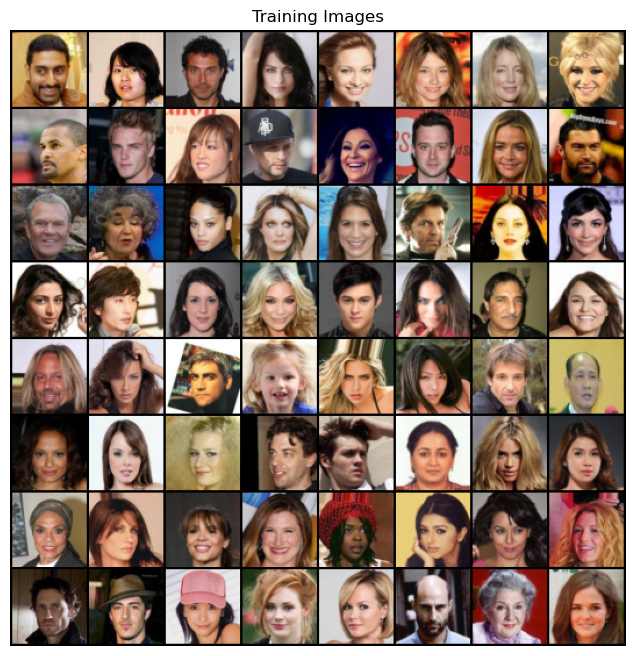

In [13]:
dataset = create_dataset(dataset_name, image_size, load_dataset_in_memory=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

In [18]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(samples, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [19]:
each_model = []
each_model_err_g = []
each_model_err_d = []
tqdm_model_params = tqdm(model_params, desc="Total Training", total=len(model_params))
for model_param in tqdm_model_params:
    batch_size, ngf, ndf, lr, beta1 = model_param.get()
    all_img_list = []
    all_G_losses = []
    all_D_losses = []
    path = f"models/{model_name}/model_saves/{dataset_name}-max_per_epoch{max_images_per_epoch}-batch_size{batch_size}-ngf{ngf}-ndf{ndf}-lr{lr}-beta1{beta1}"
    tqdm_models = tqdm(range(start_models, models), desc="Model Training")
    # tqdm_models = tqdm([1, 4, 10, 13], desc="Model Training")
    for j in tqdm_models:
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        img_list = []
        G_losses = []
        D_losses = []
        seed = set_random_seed(j)
        netG = create_generator(model, nc, nz, ngf, device, ngpu)
        netD = create_discriminator(model, nc, ndf, device, ngpu)
        torch.save(netG.state_dict(), f"{path}/generator-model{j}-epoch0.pkl")
        torch.save(netG.state_dict(), f"{path}/discriminator-model{j}-epoch0.pkl")
        # Setup Adam optimizers for both G and D
        optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
        optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
        # print(f"Starting Training Loop for model {j} with parameter {batch_size=}, {ngf=}, {ndf=}, {lr=}, {beta1=} and {seed=}...")
        # For each epoch
        tqdm_epoch = tqdm(range(1, num_epochs + 1), desc="Epochs")
        for epoch in tqdm_epoch:
            current_image_amount = 0
            # For each batch in the dataloader
            for i, data in enumerate(dataloader, 0):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                netD.zero_grad()
                # Format batch
                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                # Forward pass real batch through D
                output = netD(real_cpu).view(-1)
                # Calculate loss on all-real batch
                # print(output.shape, label.shape)
                errD_real = criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                # Generate fake image batch with G
                fake = netG(noise)
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = netD(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch, accumulated (summed) with previous gradients
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                # Compute error of D as sum over the fake and the real batches
                errD = errD_real + errD_fake
                # Update D
                optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                netG.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = netD(fake).view(-1)
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                # Update G
                optimizerG.step()
                # Output training stats
                if i % 50 == 0:
                    tqdm_epoch.set_postfix(
                        Loss_D=errD.item(),
                        Loss_G=errG.item(),
                        D_x=D_x,
                        D_G_z=D_G_z1/(D_G_z2 + 1e-10)
                    )
                    #"Loss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"%(errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())
                # increasing the current_image_amount for the max images per epoch
                current_image_amount += batch_size
                if max_images_per_epoch and current_image_amount >= max_images_per_epoch:
                    break
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            img_list.append(fake)
            torch.save(netG.state_dict(), f"{path}/generator-model{j}-epoch{epoch}.pkl")
            torch.save(netD.state_dict(), f"{path}/discriminator-model{j}-epoch{epoch}.pkl")
        all_img_list.append(img_list)
        all_G_losses.append(G_losses)
        all_D_losses.append(D_losses)
        
    each_model.append(all_img_list)
    each_model_err_g.append(all_G_losses)
    each_model_err_d.append(all_D_losses)

Total Training:   0%|          | 0/1 [00:00<?, ?it/s]

Model Training:   0%|          | 0/20 [00:00<?, ?it/s]

seed: 0


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for each_model_images_i, model_param in zip(each_model, model_params):
    each_model_images_i = np.array(each_model_images_i)
    with open(f"data/samples {model_name} {max_images_per_epoch} {model_param}.pkl") as file:
        pickle.dump(each_model_images_i, file)

In [ ]:
(batch_size, ngf, ndf, lr, beta1) = model_params[0].get()
for i, (G_losses, D_losses) in enumerate(zip(all_G_losses, all_D_losses)):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()